# Backtesting

In [1]:
import pickle

import pandas as pd
from sklearn.model_selection import train_test_split

import utils

%load_ext autoreload
%autoreload 2

### Data Preparation

In [2]:
# load dataset
df = pd.read_csv('../data/final_data.csv')

# sort by date
df = df.sort_values(by='date')
df

,date,State,adjusted_average_new_listings,adjusted_average_new_listings_yoy,average_pending_sales_listing_updates,average_pending_sales_listing_updates_yoy,off_market_in_two_weeks,off_market_in_two_weeks_yoy,adjusted_average_homes_sold,adjusted_average_homes_sold_yoy,...,months_of_supply,months_of_supply_yoy,median_pending_sqft,median_pending_sqft_yoy,average_sale_to_list_ratio,average_sale_to_list_ratio_yoy,median_sale_ppsf,median_sale_ppsf_yoy,ZORI,ZHVI
0,2016-12-30,AL,43.000000,-0.556701,52.000000,-0.174603,3.000000,-0.571429,36.000000,0.161290,...,37.555556,-11.831541,1994.000000,-0.005982,0.962797,-0.005236,99.543540,0.022577,1122.650058,216066.470760
22,2016-12-30,NM,114.313585,0.084512,134.713228,0.382836,20.912155,0.233377,49.089377,-0.202766,...,34.912703,3.409213,1581.070352,0.000619,0.968729,-0.003238,123.185945,-0.022682,1000.213260,214940.891096
23,2016-12-30,NV,73.000000,-0.401639,119.000000,-0.201342,11.000000,-0.312500,85.000000,-0.174757,...,22.976471,4.889092,1534.000000,0.009875,0.975629,-0.001425,171.276080,0.051403,1148.605311,305904.466295
24,2016-12-30,NY,151.742276,-0.169707,92.002294,-0.282131,3.498929,0.101171,96.855613,-0.176365,...,33.720803,2.649503,1349.549098,-0.060022,0.969925,0.004392,328.973719,0.029551,1895.798229,456494.835558
25,2016-12-30,OH,148.807790,-0.110787,141.400560,-0.119257,8.218554,0.395212,89.297186,-0.161583,...,30.830572,-0.016809,1560.083967,0.006244,0.960467,0.020897,76.917214,0.094313,843.742553,129419.574891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18425,2024-11-01,MA,97.090933,-0.041412,108.639851,0.122470,22.133546,0.093218,94.045135,0.329857,...,12.019740,-2.424043,1628.974114,0.013848,1.001044,-0.003737,407.260117,0.051139,2594.192374,625927.096790
18426,2024-11-01,MD,95.834211,0.211162,108.185107,0.159219,27.503864,0.048320,85.445557,0.262958,...,12.788671,-0.572449,1767.211363,-0.016668,0.998137,0.001047,221.888798,0.042522,1943.986460,396332.990533
18427,2024-11-01,ME,34.411858,0.313887,39.709881,0.830392,6.226087,0.024200,26.207115,0.097976,...,15.972631,3.528026,1569.513439,0.029284,0.975217,-0.004498,184.368299,0.006300,1536.475750,299791.577634
18416,2024-11-01,GA,25.704628,-0.165583,28.377602,-0.020919,5.882505,0.030047,21.229142,0.355209,...,21.932300,-0.595328,1743.028643,-0.022036,0.970562,-0.001474,159.285000,0.115485,1541.986132,255540.577007


### Regional Filter

In [3]:
X = df.copy()

In [4]:
# counties for each REIT
X_AVB = X[
    (X['State'] == 'CA') | (X['State'] == 'CO') | (X['State'] == 'CT') | (X['State'] == 'DC') | (
            X['State'] == 'FL') | (X['State'] == 'MD') | (X['State'] == 'MA') | (
            X['State'] == 'NJ') | (
            X['State'] == 'NY') | (X['State'] == 'NC') | (X['State'] == 'TX') | (
            X['State'] == 'VA') | (
            X['State'] == 'WA')]
X_EQR = X[
    (X['State'] == 'CA') | (X['State'] == 'CO') | (X['State'] == 'DC') | (X['State'] == 'MA') | (
            X['State'] == 'NY') | (X['State'] == 'WA')]
X_ESS = X[(X['State'] == 'CA') | (X['State'] == 'WA')]
X_INVH = X[
    (X['State'] == 'CA') | (X['State'] == 'CO') | (X['State'] == 'TX') | (X['State'] == 'NC') | (
            X['State'] == 'SC') | (X['State'] == 'GA') | (X['State'] == 'IL') | (
            X['State'] == 'FL') | (X['State'] == 'NV') | (X['State'] == 'MN') | (
            X['State'] == 'TN') | (X['State'] == 'AZ') | (X['State'] == 'WA')]

### Aggregate Rows by Date

In [5]:
X_AVB = utils.process_data(X_AVB.drop(columns='State'), utils.features_weighted, groupby='date')
X_EQR = utils.process_data(X_EQR.drop(columns='State'), utils.features_weighted, groupby='date')
X_ESS = utils.process_data(X_ESS.drop(columns='State'), utils.features_weighted, groupby='date')
X_INVH = utils.process_data(X_INVH.drop(columns='State'), utils.features_weighted, groupby='date')

### Add AlphaVantage Data

In [6]:
#Read alpha vantage data
file_path_av = "../data/av_data.csv"
df_av = pd.read_csv(file_path_av)
df_av = df_av.drop(columns=['Unnamed: 0'])
df_av

,date,SPY_adj_close,SPY_return_1day,SPY_return_1week,SPY_return_1month,SPY_return_3month,EQR_adj_close,EQR_adj_close_1day,EQR_adj_close_1week,EQR_adj_close_1month,...,AVB_adj_close_3month,INVH_adj_close,INVH_adj_close_1day,INVH_adj_close_1week,INVH_adj_close_1month,INVH_adj_close_3month,unemployment,fed_funds,3monhth_treasury_yield,cpi
0,2017-02-03,201.410539,-0.001788,0.009462,0.036496,0.045656,45.852975,45.989668,47.030055,47.402165,...,148.539775,17.272979,17.356707,17.599516,18.353064,18.018154,0.047,0.000098,0.0065,2.42839
1,2017-02-10,203.316271,0.005443,0.015464,0.027213,0.038761,47.030055,47.189531,46.764263,47.516076,...,149.262275,17.599516,17.582771,17.708362,17.900935,17.959545,0.046,0.000104,0.0066,2.43603
2,2017-02-17,206.460293,0.005955,0.008592,0.011536,0.025677,46.764263,47.402165,48.040066,47.986908,...,149.238969,17.708362,17.976290,18.260964,18.034899,17.941583,0.046,0.000102,0.0066,2.43603
3,2017-02-24,207.909361,0.001563,0.007096,-0.007860,0.016153,47.675551,48.040066,47.326224,48.178335,...,149.137974,18.085136,18.260964,18.260964,18.068390,18.193454,0.046,0.000100,0.0066,2.43603
4,2017-03-03,209.384761,-0.002978,-0.003062,-0.006931,0.017333,47.326224,47.402165,47.052837,47.627201,...,148.633001,18.260964,18.353064,17.917681,18.277709,17.933188,0.046,0.000117,0.0065,2.43603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,2024-08-16,552.612504,0.009561,0.014108,0.015389,0.083508,70.775391,70.953791,72.975662,77.078870,...,232.210000,35.000079,35.347302,35.863177,36.478257,33.830000,0.042,0.000999,0.0533,3.14796
382,2024-08-23,560.408556,-0.002384,0.002757,0.016526,0.049502,72.975662,72.281883,74.214553,76.751803,...,229.220000,35.863177,35.545716,36.547702,36.210400,34.150000,0.042,0.000990,0.0533,3.14796
383,2024-08-30,561.953809,-0.020579,-0.030638,0.021009,0.063308,74.214553,74.987622,74.432598,74.460000,...,232.900000,36.547702,36.974290,35.406826,35.260000,33.840000,0.042,0.000979,0.0533,3.14796
384,2024-09-06,538.705224,0.011196,0.040066,0.063624,0.120520,73.679352,74.432598,77.386115,73.530000,...,230.800000,35.664763,35.406826,36.726274,34.540000,33.900000,0.041,0.000968,0.0533,3.15301


In [7]:
X_AVB = pd.merge(X_AVB, df_av,
                 on=["date"],
                 how="left")
X_EQR = pd.merge(X_EQR, df_av,
                 on=["date"],
                 how="left")
X_ESS = pd.merge(X_ESS, df_av,
                 on=["date"],
                 how="left")
X_INVH = pd.merge(X_INVH, df_av,
                  on=["date"],
                  how="left")
X_AVB.dropna(inplace=True)
X_EQR.dropna(inplace=True)
X_ESS.dropna(inplace=True)
X_INVH.dropna(inplace=True)

In [8]:
# remove reit columns
columns = ['EQR_adj_close_1day', 'ESS_adj_close_1day', 'AVB_adj_close_1day', 'INVH_adj_close_1day',
           'EQR_adj_close_1week', 'ESS_adj_close_1week', 'AVB_adj_close_1week', 'INVH_adj_close_1week',
           'EQR_adj_close', 'ESS_adj_close', 'AVB_adj_close', 'INVH_adj_close', 'EQR_adj_close_1month',
           'ESS_adj_close_1month', 'AVB_adj_close_1month', 'INVH_adj_close_1month', 'EQR_adj_close_3month',
           'ESS_adj_close_3month', 'AVB_adj_close_3month', 'INVH_adj_close_3month']
X_AVB = X_AVB.drop(columns=columns)
X_EQR = X_EQR.drop(columns=columns)
X_ESS = X_ESS.drop(columns=columns)
X_INVH = X_INVH.drop(columns=columns)

### Find Backtesting Period

In [9]:
# filter backtesting period of reits (last 20% of data)
_, X_test_AVB = train_test_split(X_AVB, test_size=0.2, shuffle=False)
_, X_test_EQR = train_test_split(X_EQR, test_size=0.2, shuffle=False)
_, X_test_ESS = train_test_split(X_ESS, test_size=0.2, shuffle=False)
_, X_test_INVH = train_test_split(X_INVH, test_size=0.2, shuffle=False)

In [10]:
# find backtesting dates column sorted in ascending order
backtest_dates = X_test_AVB['date'].unique()
# remove first and last date
backtest_dates = backtest_dates[1:-1]
# print backtesting period
print(f"Backtesting period: {backtest_dates[0]} to {backtest_dates[-1]}")
print(len(backtest_dates))

Backtesting period: 2023-03-17 to 2024-09-06
76


In [11]:
# prepare output dataframe
output = pd.DataFrame(backtest_dates, columns=['date'])

## Backtesting

### Load Models

In [12]:
# load models
models = {}
with open(f'../models/AVB_ab.pkl', 'rb') as f:
    models['AVB'] = pickle.load(f)
with open(f'../models/EQR_ada.pkl', 'rb') as f:
    models['EQR'] = pickle.load(f)
with open(f'../models/ESS_ab.pkl', 'rb') as f:
    models['ESS'] = pickle.load(f)
with open(f'../models/INVH_xgb.pkl', 'rb') as f:
    models['INVH'] = pickle.load(f)

In [13]:
# Predict and aggregate for each REIT
for reit in models.keys():
    model = models[reit]
    print(f"Predicting {reit}...")

    # filter counties for the REIT
    X_test_reit = X_test_AVB if reit == 'AVB' else X_test_EQR if reit == 'EQR' else X_test_ESS if reit == 'ESS' else X_test_INVH if reit == 'INVH' else None

    # Predict for each date
    X_test_reit[f"{reit}_pred"] = model.predict(X_test_reit.drop(columns=['date']))

    # Add actual closing prices for comparison
    output = pd.merge(
        output,
        df_av[['date', f'{reit}_adj_close']],
        on='date',
        how='left'
    )

    # Add actual closing prices for comparison
    output = pd.merge(
        output,
        df_av[['date', f'{reit}_adj_close_1week']],
        on='date',
        how='left'
    )

    # merge predictions to output
    output = pd.merge(
        output,
        X_test_reit[['date', f"{reit}_pred"]],
        on='date',
        how='left'
    )

    # add actual returns
    output[f'{reit}_returns'] = output[f'{reit}_adj_close_1week'] / output[f'{reit}_adj_close'] - 1
    # add predicted returns
    output[f'{reit}_pred_returns'] = output[f'{reit}_pred'] / output[f'{reit}_adj_close'] - 1

Predicting AVB...
Predicting EQR...
Predicting ESS...
Predicting INVH...


In [14]:
# Add S&P 500 data from av_data.csv
output = pd.merge(
    output,
    df_av[['date', 'SPY_adj_close', 'SPY_return_1week']],
    on='date',
    how='left'
)

In [15]:
# Save output to CSV
output.to_csv("../data/REIT_predictions.csv", index=False)

print("Predictions saved to 'REIT_predictions.csv'")

Predictions saved to 'REIT_predictions.csv'


In [16]:
output.head()

,date,AVB_adj_close,AVB_adj_close_1week,AVB_pred,AVB_returns,AVB_pred_returns,EQR_adj_close,EQR_adj_close_1week,EQR_pred,EQR_returns,...,ESS_pred,ESS_returns,ESS_pred_returns,INVH_adj_close,INVH_adj_close_1week,INVH_pred,INVH_returns,INVH_pred_returns,SPY_adj_close,SPY_return_1week
0,2023-03-17,151.806828,148.253922,170.460002,-0.023404,0.122874,53.483744,52.622226,61.412730,-0.016108,...,231.934712,-0.030986,0.198923,28.853435,27.859794,29.989807,-0.034438,0.039384,381.979385,0.014770
1,2023-03-24,148.253922,159.559787,174.872465,0.076260,0.179547,52.622226,56.391026,61.986711,0.071620,...,238.720915,0.053475,0.273462,27.859794,29.553715,31.188221,0.060802,0.119471,387.621072,0.034466
2,2023-03-31,159.559787,160.091463,174.284437,0.003332,0.092283,56.391026,56.485011,62.435040,0.001667,...,241.003295,0.007794,0.220379,29.553715,29.941708,31.064089,0.013128,0.051106,400.980898,0.000537
3,2023-04-14,161.268745,164.563238,176.185701,0.020429,0.092497,56.428620,57.612832,62.348522,0.020986,...,236.791640,0.021545,0.205971,30.471650,31.503144,31.720392,0.033851,0.040980,403.987839,-0.000630
4,2023-04-21,164.563238,171.247166,177.297400,0.040616,0.077382,57.612832,59.445540,62.726468,0.031811,...,238.720915,0.034413,0.190156,31.503144,31.578850,31.523695,0.002403,0.000652,403.733179,0.009049


In [17]:
# Create list of return columns
return_cols = [
    'AVB_pred_returns',
    'EQR_pred_returns', 
    'ESS_pred_returns',
    'INVH_pred_returns'
]

# Get max value and corresponding REIT for each row
output['max_pred_return'] = output[return_cols].max(axis=1)
output['selected_reit'] = output[return_cols].idxmax(axis=1).str.replace('_pred_returns', '')

# Get the actual returns for the selected REIT
output['selected_actual_return'] = output.apply(
    lambda row: row[f"{row['selected_reit']}_returns"], 
    axis=1
)

output.head()

,date,AVB_adj_close,AVB_adj_close_1week,AVB_pred,AVB_returns,AVB_pred_returns,EQR_adj_close,EQR_adj_close_1week,EQR_pred,EQR_returns,...,INVH_adj_close,INVH_adj_close_1week,INVH_pred,INVH_returns,INVH_pred_returns,SPY_adj_close,SPY_return_1week,max_pred_return,selected_reit,selected_actual_return
0,2023-03-17,151.806828,148.253922,170.460002,-0.023404,0.122874,53.483744,52.622226,61.412730,-0.016108,...,28.853435,27.859794,29.989807,-0.034438,0.039384,381.979385,0.014770,0.198923,ESS,-0.030986
1,2023-03-24,148.253922,159.559787,174.872465,0.076260,0.179547,52.622226,56.391026,61.986711,0.071620,...,27.859794,29.553715,31.188221,0.060802,0.119471,387.621072,0.034466,0.273462,ESS,0.053475
2,2023-03-31,159.559787,160.091463,174.284437,0.003332,0.092283,56.391026,56.485011,62.435040,0.001667,...,29.553715,29.941708,31.064089,0.013128,0.051106,400.980898,0.000537,0.220379,ESS,0.007794
3,2023-04-14,161.268745,164.563238,176.185701,0.020429,0.092497,56.428620,57.612832,62.348522,0.020986,...,30.471650,31.503144,31.720392,0.033851,0.040980,403.987839,-0.000630,0.205971,ESS,0.021545
4,2023-04-21,164.563238,171.247166,177.297400,0.040616,0.077382,57.612832,59.445540,62.726468,0.031811,...,31.503144,31.578850,31.523695,0.002403,0.000652,403.733179,0.009049,0.190156,ESS,0.034413


In [18]:
output['cumulative_return'] = (1 + output['selected_actual_return']).cumprod() - 1
print(f"Cumulative return from {output['date'].iloc[0]} to {output['date'].iloc[-1]}: {output['cumulative_return'].iloc[-1]:.2%}")

Cumulative return from 2023-03-17 to 2024-09-06: 59.78%


KeyError: 'cumulative_return_worst'

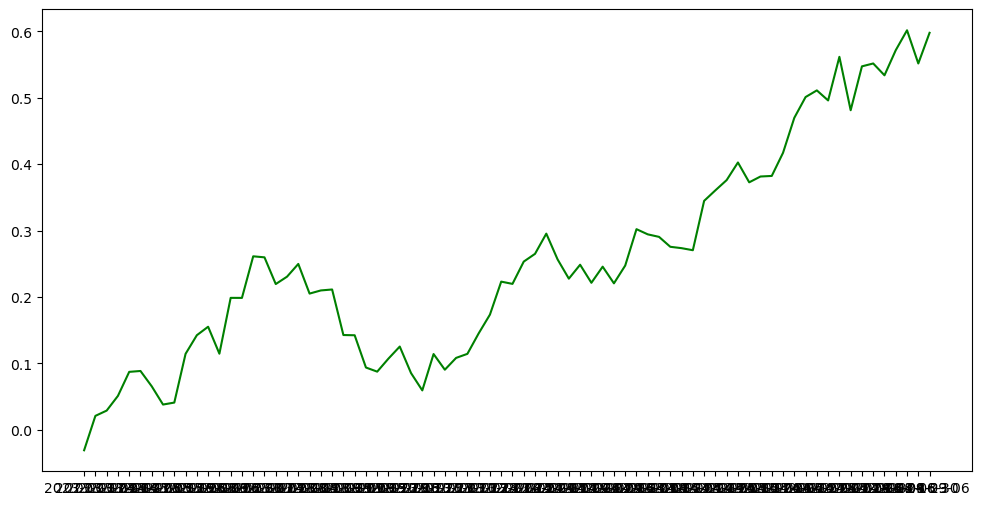

In [19]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 6))

# Plot both strategies
plt.plot(output['date'], output['cumulative_return'], label='Best Predicted Strategy', color='green')
plt.plot(output['date'], output['cumulative_return_worst'], label='Worst Predicted Strategy', color='red')

# Add a horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)

# Customize the plot
plt.title('Cumulative Returns Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.legend(fontsize=10)

# Format y-axis as percentages
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

In [23]:
# Create list of return columns
return_cols = [
    'AVB_pred_returns',
    'EQR_pred_returns', 
    'ESS_pred_returns',
    'INVH_pred_returns'
]

# Get min value and corresponding REIT for each row
output['min_pred_return'] = output[return_cols].min(axis=1)
output['selected_reit_worst'] = output[return_cols].idxmin(axis=1).str.replace('_pred_returns', '')

# Get the actual returns for the selected REIT
output['selected_actual_return_worst'] = output.apply(
    lambda row: row[f"{row['selected_reit_worst']}_returns"], 
    axis=1
)

# Calculate cumulative return for worst strategy
output['cumulative_return_worst'] = (1 + output['selected_actual_return_worst']).cumprod() - 1

print(f"Cumulative return (worst strategy) from {output['date'].iloc[0]} to {output['date'].iloc[-1]}: {output['cumulative_return_worst'].iloc[-1]:.2%}")

Cumulative return (worst strategy) from 2023-03-17 to 2024-09-06: 42.65%


Cumulative return (60/40 weighted strategy) from 2023-03-17 to 2024-09-06: 58.61%


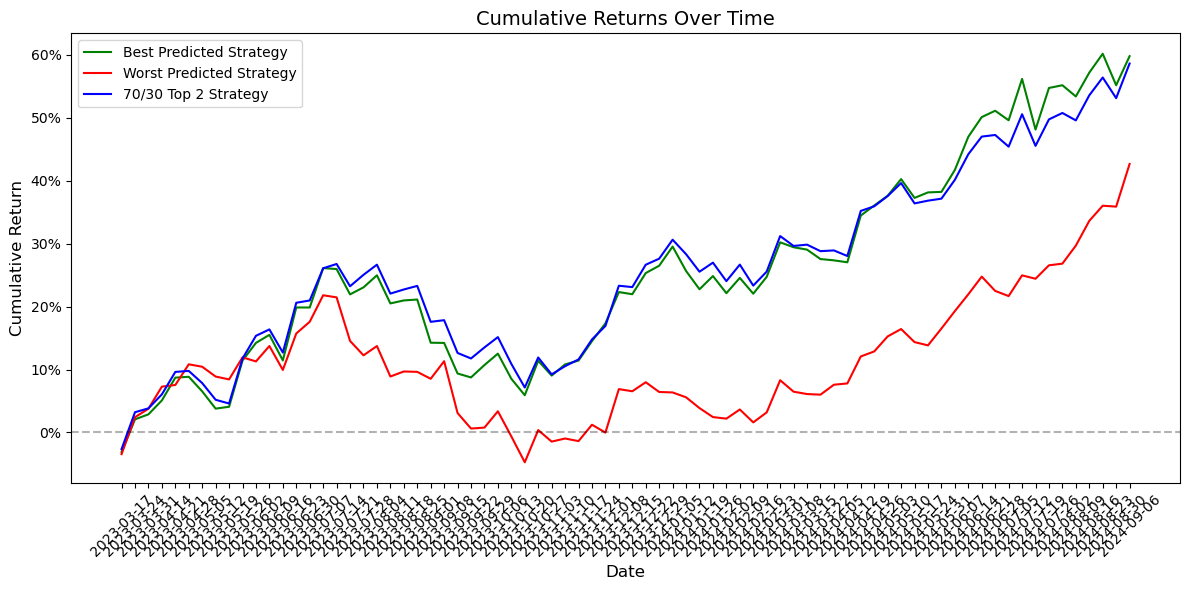

In [29]:
# Create list of return columns
return_cols = [
    'AVB_pred_returns',
    'EQR_pred_returns', 
    'ESS_pred_returns',
    'INVH_pred_returns'
]

# For each row, get the top 2 predicted returns and their corresponding REITs
output['top1_reit'] = output[return_cols].idxmax(axis=1).str.replace('_pred_returns', '')
output['top2_reit'] = output[return_cols].apply(lambda x: x.nlargest(2).index[1], axis=1).str.replace('_pred_returns', '')

# Get the actual returns for the selected REITs
output['top1_actual_return'] = output.apply(
    lambda row: row[f"{row['top1_reit']}_returns"], 
    axis=1
)
output['top2_actual_return'] = output.apply(
    lambda row: row[f"{row['top2_reit']}_returns"], 
    axis=1
)

# Calculate weighted average return (60% top1, 40% top2)
output['weighted_return'] = (0.7 * output['top1_actual_return']) + (0.3 * output['top2_actual_return'])

# Calculate cumulative return for weighted strategy
output['cumulative_return_weighted'] = (1 + output['weighted_return']).cumprod() - 1

print(f"Cumulative return (60/40 weighted strategy) from {output['date'].iloc[0]} to {output['date'].iloc[-1]}: {output['cumulative_return_weighted'].iloc[-1]:.2%}")

# Update the plot to include the new strategy
plt.figure(figsize=(12, 6))

plt.plot(output['date'], output['cumulative_return'], label='Best Predicted Strategy', color='green')
plt.plot(output['date'], output['cumulative_return_worst'], label='Worst Predicted Strategy', color='red')
plt.plot(output['date'], output['cumulative_return_weighted'], label='70/30 Top 2 Strategy', color='blue')

plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.title('Cumulative Returns Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.legend(fontsize=10)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()